In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import asyncio
import urllib.request

#Check if GPU is fried yet
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y']
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X.reshape(X.shape[0], 50, 50, 1) / 255

In [3]:
X.shape

(10000, 50, 50, 1)

In [4]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

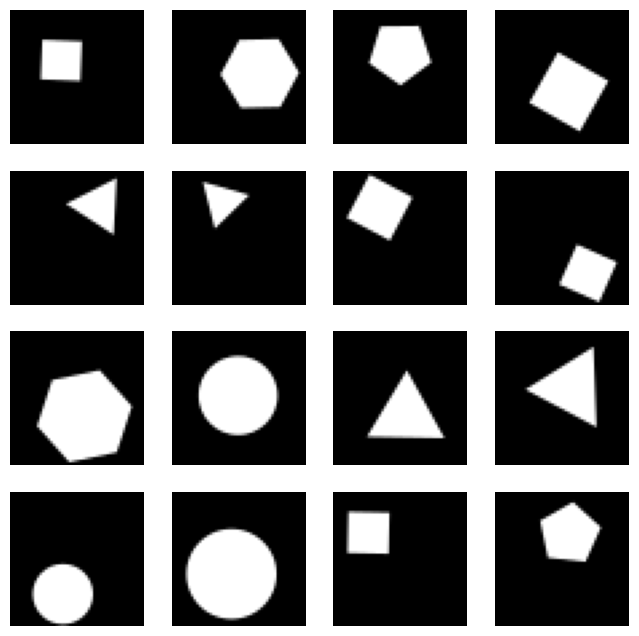

In [5]:
#Original data visualisation

data_generator = ImageDataGenerator()
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

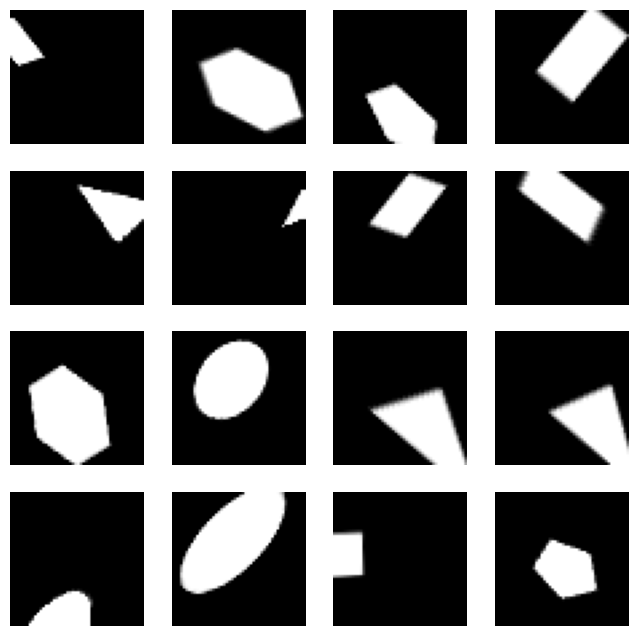

In [6]:
#Data augmentation visualisation

data_generator = ImageDataGenerator(
    rotation_range = 90,
    zoom_range = 0.2,
    shear_range = 45,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    channel_shift_range = 0.9,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

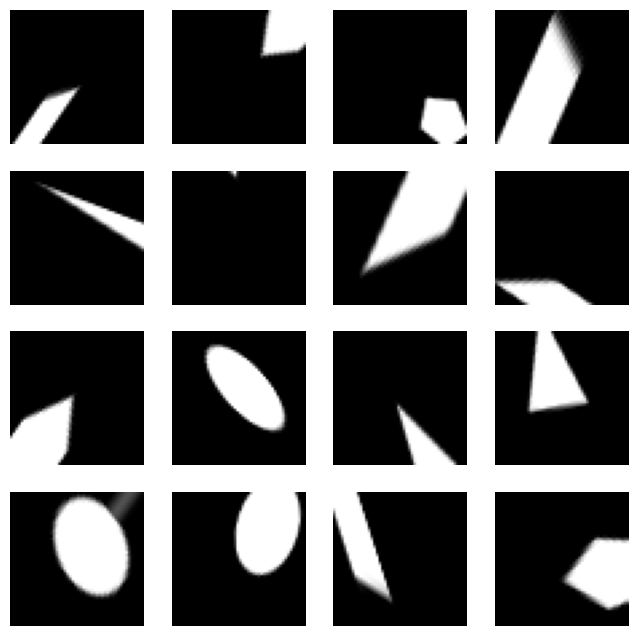

In [7]:
#Train for the worst

data_generator = ImageDataGenerator(
    rotation_range = 180,
    zoom_range = 0.5,
    shear_range = 70,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.25,
    width_shift_range = 0.25,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

In [8]:
#99.48% on advanced model

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(128, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'original_99.48_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 64, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 16, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/64, epochs = 200, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856 

125/125 [==============================] - 4s 33ms/step - loss: 0.5727 - accuracy: 0.7964 - val_loss: 0.4693 - val_accuracy: 0.8360
Epoch 91/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5629 - accuracy: 0.8029 - val_loss: 0.4681 - val_accuracy: 0.8315
Epoch 92/200
125/125 [==============================] - 4s 35ms/step - loss: 0.5478 - accuracy: 0.8044 - val_loss: 0.4411 - val_accuracy: 0.8360
Epoch 93/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5717 - accuracy: 0.7996 - val_loss: 0.4870 - val_accuracy: 0.8130
Epoch 94/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5693 - accuracy: 0.8020 - val_loss: 0.4608 - val_accuracy: 0.8285
Epoch 95/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5539 - accuracy: 0.8014 - val_loss: 0.4612 - val_accuracy: 0.8305
Epoch 96/200
125/125 [==============================] - 4s 33ms/step - loss: 0.5545 - accuracy: 0.8071 - val_loss: 0.4459 - val_accuracy: 0.844

<AxesSubplot: >

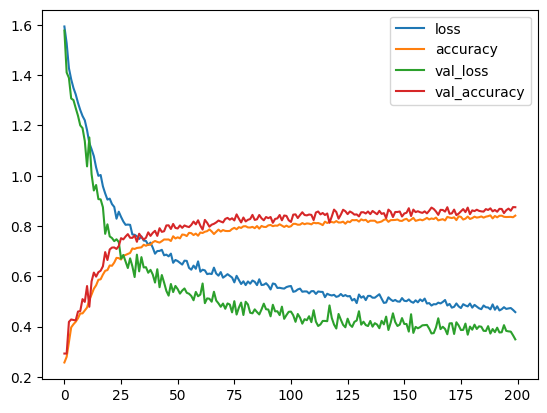

In [9]:
#Funny squiggles

pd.DataFrame(hist.history).plot()

In [10]:
#Fail

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'failed_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 64, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 16, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/64, epochs = 200, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       7385

125/125 [==============================] - 4s 35ms/step - loss: 0.5344 - accuracy: 0.8158 - val_loss: 0.4916 - val_accuracy: 0.8410
Epoch 84/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5193 - accuracy: 0.8256 - val_loss: 0.4661 - val_accuracy: 0.8620
Epoch 85/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5427 - accuracy: 0.8200 - val_loss: 0.5234 - val_accuracy: 0.8270
Epoch 86/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5193 - accuracy: 0.8244 - val_loss: 0.5052 - val_accuracy: 0.8580
Epoch 87/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5460 - accuracy: 0.8164 - val_loss: 0.4409 - val_accuracy: 0.8545
Epoch 88/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5058 - accuracy: 0.8264 - val_loss: 0.4699 - val_accuracy: 0.8625
Epoch 89/200
125/125 [==============================] - 4s 34ms/step - loss: 0.5095 - accuracy: 0.8256 - val_loss: 0.4375 - val_accuracy: 0.873

125/125 [==============================] - 4s 34ms/step - loss: 0.4444 - accuracy: 0.8513 - val_loss: 0.4522 - val_accuracy: 0.8695
Epoch 196/200
125/125 [==============================] - 4s 34ms/step - loss: 0.4305 - accuracy: 0.8656 - val_loss: 0.3973 - val_accuracy: 0.8795
Epoch 197/200
125/125 [==============================] - 4s 34ms/step - loss: 0.4362 - accuracy: 0.8565 - val_loss: 0.4068 - val_accuracy: 0.8725
Epoch 198/200
125/125 [==============================] - 4s 34ms/step - loss: 0.4268 - accuracy: 0.8610 - val_loss: 0.4533 - val_accuracy: 0.8630
Epoch 199/200
125/125 [==============================] - 4s 34ms/step - loss: 0.4356 - accuracy: 0.8581 - val_loss: 0.4183 - val_accuracy: 0.8875
Epoch 200/200
125/125 [==============================] - 4s 34ms/step - loss: 0.4158 - accuracy: 0.8659 - val_loss: 0.3924 - val_accuracy: 0.8835


<AxesSubplot: >

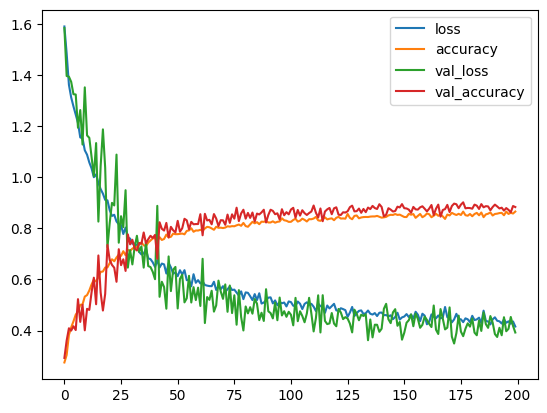

In [11]:
#More funny squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
#Model that got 100% on advanced

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(5, 5), padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(4, 4), padding = 'same')(out);
out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'best_100_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 64, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 16, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/64, epochs = 200, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 32)        832       
                                                                 
 activation (Activation)     (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 25, 25, 64)        0         
                                                           

In [ ]:
#Even more funny squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
#Load the winner, continue training and save all epochs for... reasons

model = tf.keras.models.load_model('best_100_model.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 64, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 16, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/64, epochs = 70, callbacks = [checkpoint]);

In [ ]:
#Here's a little lesson in trickery

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

@background
def brute_force(x):
    url = 'https://us-central1-aiprimer.cloudfunctions.net/flatland?model_link=https://github.com/DDomjosa/flatland/blob/main/epochs/'+str(x)+'model.h5?raw=true';
    uf = urllib.request.urlopen(url)
    html = uf.read()
    print('Epoch = ' + str(x) + ':\n\n' + html.decode("utf-8") + '\n')
    
for i in range(1, 71):
    brute_force(i)

In [17]:
inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(8, kernel_size=(3, 3), activation = 'relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Conv2D(8, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
#out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
#out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 50, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 50, 50, 8)         80        
                                                                 
 conv2d_49 (Conv2D)          (None, 50, 50, 8)         584       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 25, 25, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 25, 25, 16)        1168      
                                                                 
 conv2d_51 (Conv2D)          (None, 25, 25, 16)        2320      
                                                           

80/80 [==============================] - 4s 49ms/step - loss: 0.7543 - accuracy: 0.7143 - val_loss: 0.7259 - val_accuracy: 0.7255
Epoch 38/50
80/80 [==============================] - 4s 48ms/step - loss: 0.7770 - accuracy: 0.6955 - val_loss: 0.7681 - val_accuracy: 0.7035
Epoch 39/50
80/80 [==============================] - 4s 48ms/step - loss: 0.7575 - accuracy: 0.7146 - val_loss: 0.7048 - val_accuracy: 0.7340
Epoch 40/50
80/80 [==============================] - 4s 49ms/step - loss: 0.7431 - accuracy: 0.7145 - val_loss: 0.6903 - val_accuracy: 0.7425
Epoch 41/50
80/80 [==============================] - 4s 48ms/step - loss: 0.7558 - accuracy: 0.7105 - val_loss: 0.7234 - val_accuracy: 0.7300
Epoch 42/50
80/80 [==============================] - 4s 50ms/step - loss: 0.7466 - accuracy: 0.7150 - val_loss: 0.6767 - val_accuracy: 0.7440
Epoch 43/50
80/80 [==============================] - 4s 51ms/step - loss: 0.7214 - accuracy: 0.7230 - val_loss: 0.7407 - val_accuracy: 0.6990
Epoch 44/50
80/80 